$\textbf{Machine Intelligence Exercise Sheet 7}$\
Belugas on the Run

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy.stats as stats
from sklearn.cluster import KMeans

$\textbf{Exercise 1: Training data}$

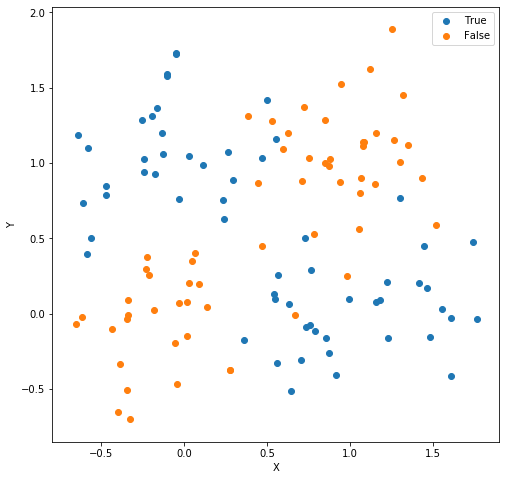

In [2]:
mean1 = np.array([0,1])
mean2 = np.array([1,0])
mean3 = np.array([0,0])
mean4 = np.array([1,1])

cov = np.eye(2) * .1


def generate_data (nsamples, mean1, mean2, cov1, cov2):
    
    """
    Generates a number of samples from multivariate normal
    distributions with different means. 
    
    @params:
    nsamples: the number of samples to be generated
    mean1: the mean of the first multivariate gaussian
    mean2: the mean of the second multivariate gaussian
    cov1: the covariance matrix of the first mg
    cov2: the covariances matrix of the second mg
    """
    
    one = np.random.multivariate_normal(mean1, cov1, nsamples)
    two = np.random.multivariate_normal(mean2, cov2, nsamples)
    
    mask = np.random.choice(np.array([True, False]), nsamples)
    
    data = one[mask]
    data2 = two[np.invert(mask)]
    
    return np.concatenate((data, data2), axis=0)

#Generating data: for multiclass classification we need arrays of length 3:

data1 = np.zeros((60,5))
data1[:,0:2] = (generate_data(60, mean1, mean2, cov, cov))
data1[:,2] = np.ones(60)
data1[:,3] = np.zeros(60)
data1[:,4] = np.zeros(60)

data2 = np.zeros((60,5))
data2[:,0:2] = (generate_data(60, mean3, mean4, cov, cov))
data2[:,2] = np.zeros(60)
data2[:,3] = np.ones(60)
data2[:,4] = np.zeros(60)

plt.figure(figsize = (8,8))

plt.scatter(data1[:,0], data1[:,1], label = 'True')
plt.scatter(data2[:,0], data2[:,1], label = 'False')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

$\textbf{Exercise 2: $\textit{k}$-nearest neighbour}$

In [3]:
training_data = np.concatenate((data1[:,0:3], data2[:,0:3]), axis = 0) 

def k_classify(k, query, data, M):
    
    """
    Classifies query points using the k-nearest neighbour algorithm
    @params:
    k: number of points to compose the electoral comittee
    query: the query point 
    data: a set of training vectors
    M: number of classes to classify 
    """
    
    #Get euclidean distances:
    
    euclidean = np.array([distance.euclidean(query, dpoint[:2]) for dpoint in data])
    
    distance_matrix = np.zeros((data.shape[0], data.shape[1]+1))
    distance_matrix[:,0] = euclidean
    distance_matrix[:,1:3] = data[:,0:2]
    distance_matrix[:,3:M+3] = data[:,2:M+2]
    
    #Sort the distance matrix:
    
    distance_matrix = distance_matrix[distance_matrix[:,0].argsort()]
    
    #Get the neighbours:
    
    neighbours = distance_matrix[:k]
    
    prediction = np.argmax(stats.mode(neighbours[:,3:(M+3)])[0])
    
    return prediction






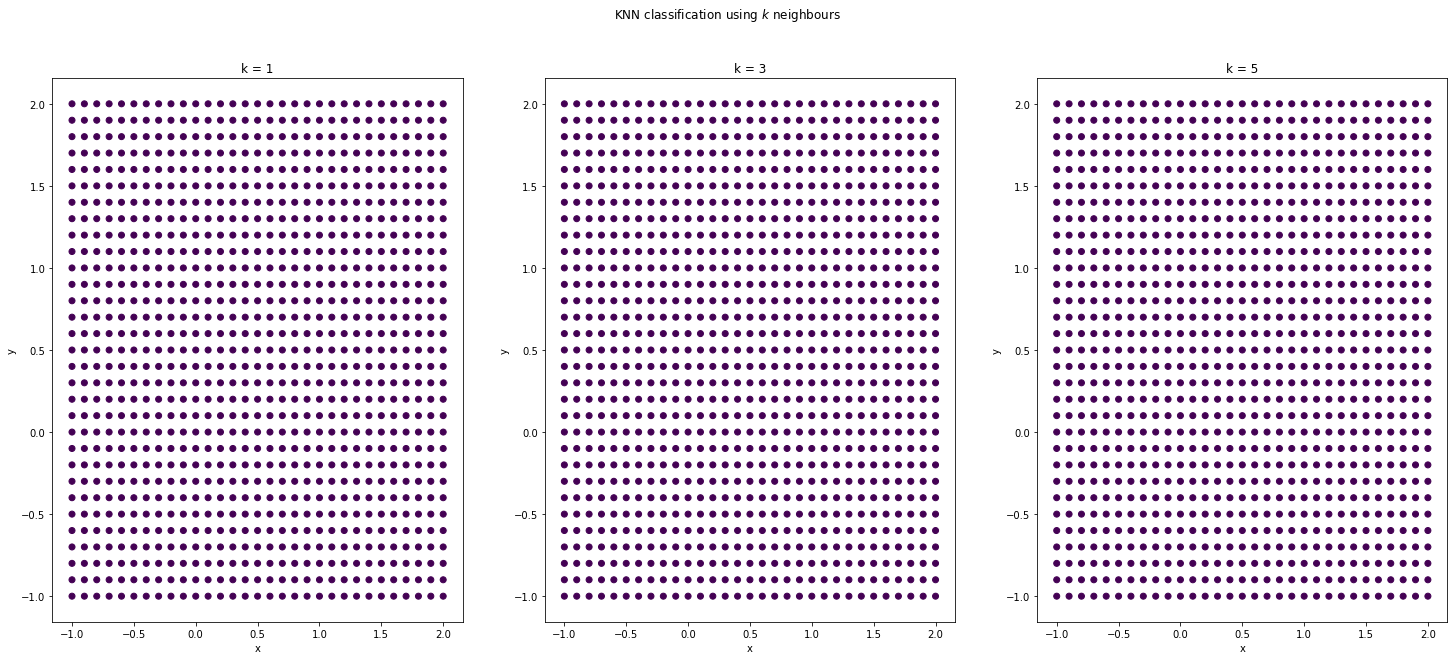

In [4]:
#Defining hyperparameters & input range:

hyp_arr = np.array([1,3,5])
x_range = np.arange(-1,2.1,.1)
y_range = np.arange(-1,2.1,.1)

input_space = np.array([[x,y] for x in x_range for y in y_range]) 

#Classify input range:

def classify_grid (k, grid, data, M):

    prediction = np.zeros(input_space.shape[0])

    for qi in range(grid.shape[0]):
    
        prediction[qi] = k_classify(k, grid[qi], data, M)

    return prediction

#Plotting the results:

fig, axs = plt.subplots(1, hyp_arr.shape[0], figsize = (25,10))

plt.suptitle('KNN classification using $k$ neighbours')

for kI, k in np.ndenumerate(hyp_arr):
    
    prediction = classify_grid(k, input_space, training_data, 2)

    axs[kI].scatter(input_space[:,0], input_space[:,1], c = prediction)
    axs[kI].set_title('k = {}'.format(k))
    axs[kI].set_xlabel('x')
    axs[kI].set_ylabel('y')

$\textbf{Answer:} $We can see that as $k$ grows, the classifier becomes more robust to outliers in the training data. The class countours begin to approximate squares centred at the respective means of the gaussian distributions. This is as expected. As we take more neighbours into account we move toward the bias end of the bias-variance trade-off. As we do so, the impact of outliers in the training data becomes much less pronounced.

$\textbf{Exercise 3: "Parzen Window" classifier}$

In [5]:
#Part (a): Parzen Window classification

def kernel (x, x_a, sigma):
    
    norm = distance.euclidean(x,x_a)
    factor = - 1 / sigma
    
    return np.exp(factor * norm)

#Define hyperparameters of the kernel:

sigma_arr = np.array([.01,.1,.5])

In [6]:
#Define Parzen Window:

def parzen_window (sigma, query, data, M): # for multiclass classification
    

    """
    Calculates the predicted class of a single data point
    @params:
    sigma: variance of the kernels
    query: the query point
    data: the training data
    M: the number of classes
    """
    
    partial_kernel = lambda d_point: kernel(query, d_point, sigma)
    
    kernel_results = np.array([partial_kernel(d_point) for d_point in data[:,:2]])
    
    prediction = np.dot(data[:,2:M+2].T, kernel_results) / np.sum(kernel_results)
    
    return np.argmax(prediction)


NameError: name 'multiclass_data' is not defined

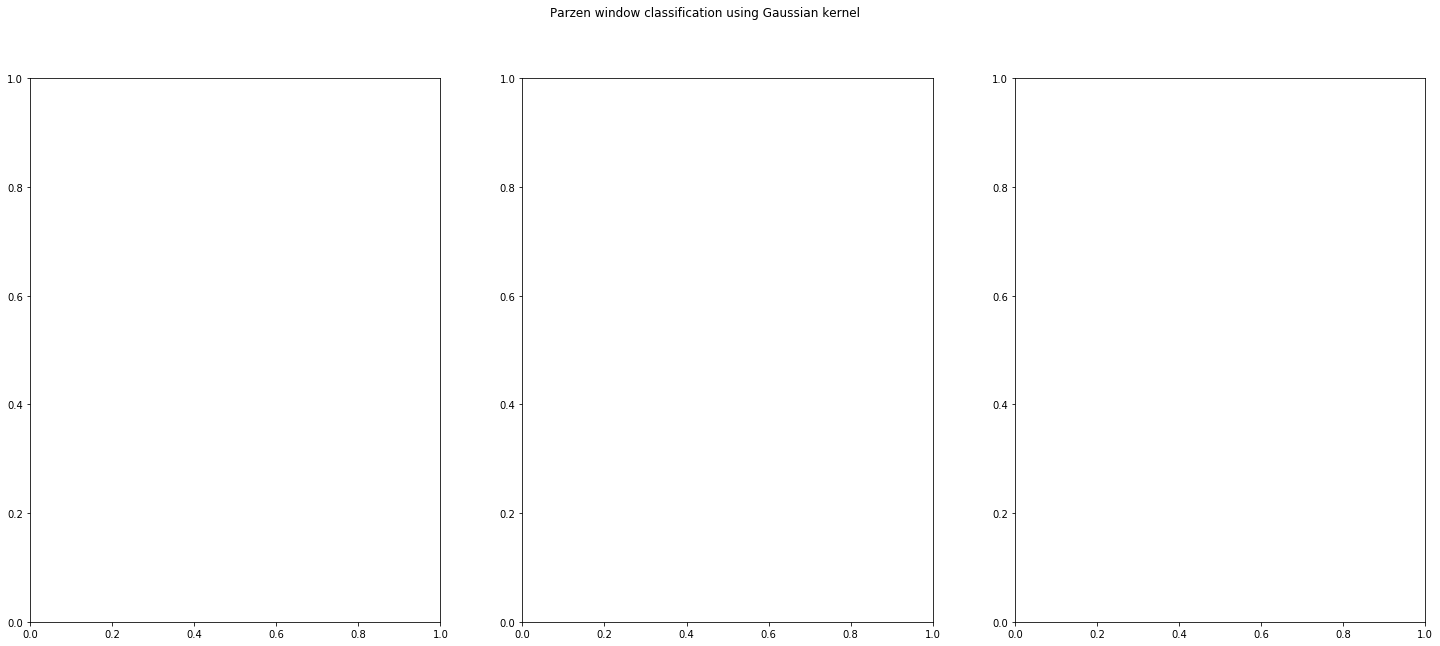

In [8]:
#Classify the training data: these functions should be adjusted later for higher generality

def parzen_classify(sigma, grid, data, M): # multi-class
    
    """
    Applies a Parzen window to a range of input values
    @params: exactly as for parzen window function

    """
    
    parzen_partial = lambda query: parzen_window(sigma, query, multiclass_data, M)
    
    prediction = np.array(list(map(parzen_partial, grid)))
    
    return prediction
    
#Plotting predictions for different sigmas:

fig, axs = plt.subplots(1, sigma_arr.shape[0], figsize = (25,10))

plt.suptitle('Parzen window classification using Gaussian kernel')

for sI, sigma in np.ndenumerate(sigma_arr):
    
    prediction = parzen_classify(sigma, input_space, training_data, 2)

    axs[sI].scatter(input_space[:,0], input_space[:,1], c = prediction)
    axs[sI].set_title('$\sigma$ = {}'.format(sigma))
    axs[sI].set_xlabel('x')
    axs[sI].set_ylabel('y')

$\textbf{Answer:}$ Same as before, we can observe the bias-variance trade-off at work. As we decrease the variance of the Gaussian bell, the model seems to become more susceptible to outliers and hence more susceptible to overfitting. This is because, at low variance the bells around the data points will becomes smaller and smaller in diameter and any query point will still only see its local neighbourhood. Actually, we can see that this plotis (almost) exactly like the leftmost plot for the $k$$\textbf{NN}$ classfier (meaning that at such low variance, the parzen window is actually looking only at its closest neighbour).

$\textbf{Part [b]: Re-running classifiers with added data}$

In [ ]:
#Generating points in new class: this can be done much more elegantly and will be tonight

mean5 = np.array([.5,.5])

data3 = np.zeros((60,5))
data3[:,0:2] = (generate_data(60, mean5, mean5, cov, cov))
data3[:,2] = np.zeros(60) 
data3[:,3] = np.zeros(60) 
data3[:,4] = np.ones(60)

plt.figure(figsize = (8,8))

plt.scatter(data1[:,0], data1[:,1],  label = 'Class 1')
plt.scatter(data2[:,0], data2[:,1], label = 'Class 2')
plt.scatter(data3[:,0], data3[:,1], label = 'Class 3')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

multiclass_data = np.concatenate((data1, data2, data3), axis = 0)


In [ ]:
#Plotting kNN for three classes:

fig, axs = plt.subplots(1, hyp_arr.shape[0], figsize = (25,10))

plt.suptitle('KNN classification using $k$ neighbours')

for kI, k in np.ndenumerate(hyp_arr):
    
    prediction = classify_grid(k, input_space, multiclass_data, 3)

    axs[kI].scatter(input_space[:,0], input_space[:,1], c = prediction)
    axs[kI].set_title('k = {}'.format(k))
    axs[kI].set_xlabel('x')
    axs[kI].set_ylabel('y')

In [ ]:
#Plotting Parzen Window for three classes:

fig, axs = plt.subplots(1, sigma_arr.shape[0], figsize = (25,10))

plt.suptitle('Parzen window classification using Gaussian kernel')

for sI, sigma in np.ndenumerate(sigma_arr):
    
    prediction = parzen_classify_2(sigma, input_space, multiclass_data, 3)

    axs[sI].scatter(input_space[:,0], input_space[:,1], c = prediction)
    axs[sI].set_title('$\sigma$ = {}'.format(sigma))
    axs[sI].set_xlabel('x')
    axs[sI].set_ylabel('y')


$\textbf{Answer}$: Again, we can see the the same relationship between the $k$$\textbf{NN}$ and the Parzen window as before. Especially the leftmost plots look fairly alike again, since in both cases query points see only their local neighbourhood. 

$\textbf{Exercise 4: RBF Networks}$

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
#Defining hyperparameters:

means_arr = np.array([2,3,4])

#Classify the grid using an RBF network:

def rbf_classify(k, grid, data, sigma, k_cluster):
    
    """
    Classifies input data using rbf-network with kernel function
    @params:
    k: number of kernels ot use
    grid: 2-D array of query points
    data: the training data including class labels
    sigma: variance of the kernel function
    k_cluster: bool – if true use kmeans clustering, 
    else use predefined centres 

    """
    
    if k_cluster:
    
        kmeans = KMeans(n_clusters = k, random_state = 0).fit(data[:,:2]).cluster_centers_
    
    else:
        
        kmeans = np.zeros((2,2))
        kmeans[0,:] = np.zeros(2)
        kmeans[1,:] = np.ones(2)
    
    bias = np.array([1])
    
    #Transforming the query data:
    
    phi = lambda query : np.append(bias, np.array([kernel(query, mean, sigma) for mean in kmeans]))
    
    #Getting optimal weights:
    
    Phi_data = np.array([phi(d_point) for d_point in data[:,:2]]).T
    
    w = np.linalg.inv(Phi_data @ Phi_data.T) @ Phi_data @ data[:,2]
    
    #Generating prediction:
    
    Phi_query = np.array([phi(query) for query in grid])

    prediction = w.T @ Phi_query.T
    prediction = np.where(prediction < .5, 1, 0)

    return prediction, kmeans


In [ ]:
means_arr = np.array([2,3,4])
sigma_add = np.array([1])

for sI, sigma in np.ndenumerate(np.append(sigma_arr, sigma_add)):
    
    fig, axs = plt.subplots(1, means_arr.shape[0], figsize = (25,10))
    
    plt.suptitle('RBF network: $\sigma$ ={} '. format(sigma))

    for mI, nmeans in np.ndenumerate(means_arr):
    
        result = rbf_classify(nmeans, input_space, training_data1, sigma, True)
        prediction = result[0]
        kmeans = result[1]

        axs[mI].scatter(input_space[:,0], input_space[:,1], c = prediction)
        axs[mI].scatter(kmeans[:,0], kmeans[:,1] , c = 'red', label = 'centres')
        axs[mI].set_title('#means ={}'.format(kmeans.shape[0]) )
        axs[mI].set_xlabel('x')
        axs[mI].set_ylabel('y')
        axs[mI].legend()

$\textbf{Answer:}$ The classifier improves both as we increase the number of centres and with increases in the variance of the Gaussian bell. Principally, four centres should be enough to learn the shape of the data, but at different variances the narrow shape of the Gaussian bell still leads the network to misclassify a lot of data points. For $\sigma$ = 1 we observe pretty good convergence of predictions to the actual shape of the input data.

In [ ]:
def two_centre(data, sigma = .45):
    
    centres = np.zeros((2,2))
    centres[0,:] = np.zeros(2)
    centres[1,:] = np.ones(2)
    
    Phi = lambda i: np.array([kernel(centres[i,:], d_point, sigma) for d_point in data[:,:2]])
    
    bias = np.array([1])
    
    phi = lambda query : np.append(bias, np.array([kernel(query, mean, sigma) for mean in kmeans]))
    
    Phi_data = np.array([phi(d_point) for d_point in data[:,:2]]).T

    return Phi(0), Phi(1)

xv, yv = two_centre(training_data1)[0], two_centre(training_data1)[1]

prediction = np.where(xv + yv > .5, 1, 0)
after_training = rbf_classify(2, training_data1[:,:2], training_data1, .5, False)[0]

fig, axs = plt.subplots(1,2, sharey = True, sharex = True, figsize = (20,10))                             
               
plt.suptitle('$\phi_1$ vs. $\phi_2$')    
axs[0].scatter(xv,yv, c = prediction)
axs[0].set_title('Pre-training')
axs[0].set_xlabel('$\phi_1$')
axs[0].set_ylabel('$\phi_2$')
axs[1].scatter(xv,yv, c = after_training)
axs[1].set_title('Post-training')
axs[1].set_xlabel('$\phi_1$')
axs[1].set_ylabel('$\phi_2$')
